## Linking Child Enrolment Pressure with Biometric Update Workload

Objective:  
To examine whether districts with higher child enrolment pressure also experience higher biometric update workloads, indicating combined operational stress on enrolment infrastructure.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
df1 = pd.read_csv('UIDAI-2026/api_data_aadhar_biometric/api_data_aadhar_biometric_0_500000.csv')
df2 = pd.read_csv('UIDAI-2026/api_data_aadhar_biometric/api_data_aadhar_biometric_500000_1000000.csv')
df3 = pd.read_csv('UIDAI-2026/api_data_aadhar_biometric/api_data_aadhar_biometric_1000000_1500000.csv')
df4 = pd.read_csv('UIDAI-2026/api_data_aadhar_biometric/api_data_aadhar_biometric_1500000_1861108.csv')



In [3]:
df = pd.concat([df1,df2,df3,df4],ignore_index=True)
df.isnull().sum()

date            0
state           0
district        0
pincode         0
bio_age_5_17    0
bio_age_17_     0
dtype: int64

In [4]:
df['date'].value_counts().sum()
df

,date,state,district,pincode,bio_age_5_17,bio_age_17_
0,01-03-2025,Haryana,Mahendragarh,123029,280,577
1,01-03-2025,Bihar,Madhepura,852121,144,369
2,01-03-2025,Jammu and Kashmir,Punch,185101,643,1091
3,01-03-2025,Bihar,Bhojpur,802158,256,980
4,01-03-2025,Tamil Nadu,Madurai,625514,271,815
...,...,...,...,...,...,...
1861103,29-12-2025,West Bengal,Uttar Dinajpur,733201,4,9
1861104,29-12-2025,West Bengal,Uttar Dinajpur,733213,0,1
1861105,29-12-2025,West Bengal,West Midnapore,721304,0,3
1861106,29-12-2025,West Bengal,West Midnapore,721451,2,0


In [5]:
df.columns

Index(['date', 'state', 'district', 'pincode', 'bio_age_5_17', 'bio_age_17_'], dtype='object')

In [6]:
df['date'] = pd.to_datetime(df['date'],dayfirst=True,errors = "coerce")
df['month'] = df['date'].dt.month_name() 


In [7]:
df['month'].value_counts().sum()

np.int64(1861108)

In [8]:
df = df.drop(columns=['date'])

In [9]:
df = df.rename(columns={
    'bio_age_5_17':'children(5-17)',
    'bio_age_17_' : 'adults'
})

In [10]:
df = df[[
    "month",
    "state",
    "district",
    "pincode",
    "children(5-17)",
    "adults"
]]

In [11]:
df.loc[:,'biometric_total'] = df['children(5-17)'] + df['adults']

In [12]:
bio_district_df =(
    df
    .groupby(['month','state','district'],as_index=False)
    .agg({
        'biometric_total': "sum"
    })
)

### Monthly Trend of Biometric Updates (All Districts)

This chart shows overall monthly biometric update workload across all districts.


In [13]:
month_order = [
    "January","February","March","April","May","June",
    "July","August","September","October","November","December"
]

bio_district_df["month"] = pd.Categorical(
    bio_district_df["month"],
    categories=month_order,
    ordered=True
)

C:\Users\palas\AppData\Local\Temp\ipykernel_18004\2705943003.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("month",as_index=False)["biometric_total"]


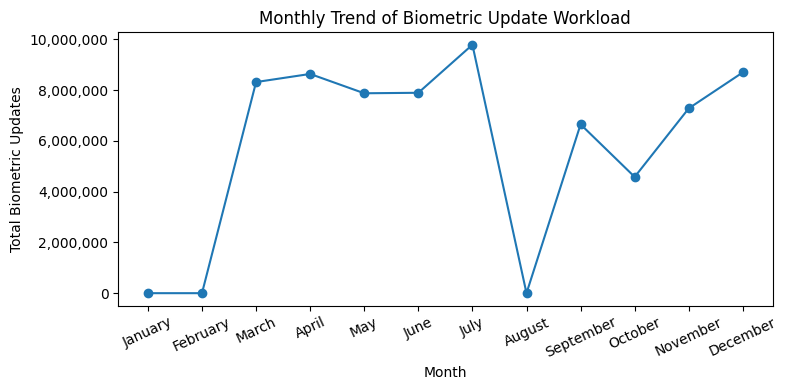

In [14]:
monthly_bio = (
    bio_district_df
    .groupby("month",as_index=False)["biometric_total"]
    .sum()
    .sort_values('month') #type:ignore
)


fig, ax = plt.subplots(figsize=(8,4))
ax.plot(monthly_bio["month"], monthly_bio["biometric_total"], marker="o")
ax.set_xlabel("Month")
ax.set_ylabel("Total Biometric Updates")
ax.set_title("Monthly Trend of Biometric Update Workload")
plt.xticks(rotation=25)

ax.yaxis.set_major_formatter(
    ticker.StrMethodFormatter('{x:,.0f}')
)

plt.tight_layout()
plt.show()


**Observation:** Biometric update workload varies across months, indicating that operational demand fluctuates over time rather than remaining constant throughout the year.


In [15]:
district_df = pd.read_csv('district_pressure.csv')

In [16]:
district_df.columns

Index(['month', 'state', 'district', 'children(0-5)', 'children(5-17)',
       'adults', 'child_total', 'total_enrolment', 'child_share',
       'state_avg_child_share', 'pressure_score'],
      dtype='object')

In [17]:
bio_district_df.columns

Index(['month', 'state', 'district', 'biometric_total'], dtype='object')

In [18]:
#Merging_df
combined_df = pd.merge(
    district_df,
    bio_district_df,
    on=['month','state','district'],
    how='inner'
)

In [19]:
combined_df

,month,state,district,children(0-5),children(5-17),adults,child_total,total_enrolment,child_share,state_avg_child_share,pressure_score,biometric_total
0,April,Assam,Baksa,408,483,187,891,1078,0.826531,0.804274,0.022257,3072
1,April,Assam,Barpeta,138,54,23,192,215,0.893023,0.804274,0.088750,11969
2,April,Assam,Biswanath,104,114,32,218,250,0.872000,0.804274,0.067726,1786
3,April,Assam,Bongaigaon,221,87,61,308,369,0.834688,0.804274,0.030415,5647
4,April,Assam,Cachar,988,461,299,1449,1748,0.828947,0.804274,0.024674,12349
...,...,...,...,...,...,...,...,...,...,...,...,...
4949,September,West Bengal,nadia,1,0,0,1,1,1.000000,0.986031,0.013969,1
4950,September,West bengal,hooghly,1,1,0,2,2,1.000000,1.000000,0.000000,4
4951,September,Westbengal,Hooghly,1,1,0,2,2,1.000000,1.000000,0.000000,5
4952,September,andhra pradesh,chittoor,1,0,0,1,1,1.000000,1.000000,0.000000,10


In [20]:
analysis_df = combined_df[["month","state","district","pressure_score","biometric_total"]]
analysis_df

,month,state,district,pressure_score,biometric_total
0,April,Assam,Baksa,0.022257,3072
1,April,Assam,Barpeta,0.088750,11969
2,April,Assam,Biswanath,0.067726,1786
3,April,Assam,Bongaigaon,0.030415,5647
4,April,Assam,Cachar,0.024674,12349
...,...,...,...,...,...
4949,September,West Bengal,nadia,0.013969,1
4950,September,West bengal,hooghly,0.000000,4
4951,September,Westbengal,Hooghly,0.000000,5
4952,September,andhra pradesh,chittoor,0.000000,10


### Relationship Between Child Enrolment Pressure and Biometric Update Workload

This scatter plot examines whether districts with higher child enrolment pressure also experience higher biometric update workload, indicating combined operational stress.


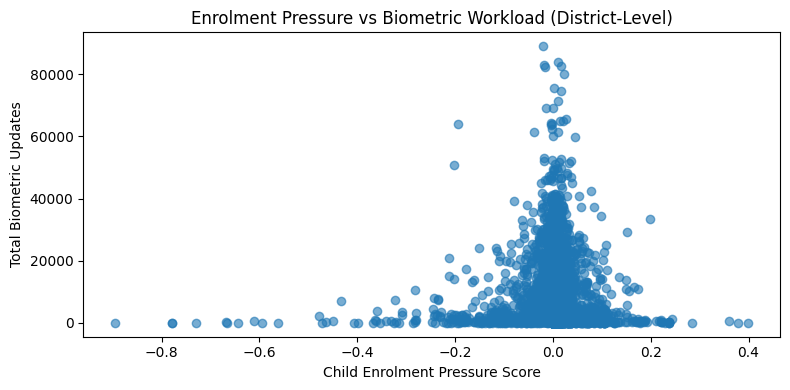

In [21]:
fig, ax = plt.subplots(figsize=(8, 4))

ax.scatter(
    analysis_df["pressure_score"],
    analysis_df["biometric_total"],
    alpha=0.6
)

ax.set_xlabel("Child Enrolment Pressure Score")
ax.set_ylabel("Total Biometric Updates")
ax.set_title("Enrolment Pressure vs Biometric Workload (District-Level)")

plt.tight_layout()
plt.show()

In [22]:
#Threshold Selection
pressure_thresshold = analysis_df['pressure_score'].quantile(0.75)
biometric_thresshold = analysis_df['biometric_total'].quantile(0.75)

pressure_thresshold,biometric_thresshold

(np.float64(0.0125105660756598), np.float64(12241.0))

In [23]:
## function to categories district 

def classify(row):
    if row['pressure_score'] >=pressure_thresshold and row['biometric_total'] >=biometric_thresshold:
        return "High Workload"
    elif row['pressure_score'] >=pressure_thresshold and row['biometric_total'] <=biometric_thresshold:
        return "Enrolment-Focused"
    elif row['pressure_score'] <= pressure_thresshold and row['biometric_total'] >=biometric_thresshold:
        return "Update-Focused"
    else:
        return "Stable"
    

In [24]:
##adding category Column in analysis_df
analysis_df.loc[:,'district_type'] = analysis_df.apply(classify,axis=1)

C:\Users\palas\AppData\Local\Temp\ipykernel_18004\1461644960.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analysis_df.loc[:,'district_type'] = analysis_df.apply(classify,axis=1)


### District Classification Based on Enrolment Pressure and Biometric Workload

Districts are grouped into four operational categories based on whether they exhibit high or low enrolment pressure and biometric update workload.


In [25]:
category_counts = analysis_df['district_type'].value_counts().reset_index()
category_counts.columns = ['district_type','count'] 
category_counts

,district_type,count
0,Stable,2771
1,Enrolment-Focused,943
2,Update-Focused,938
3,High Workload,302


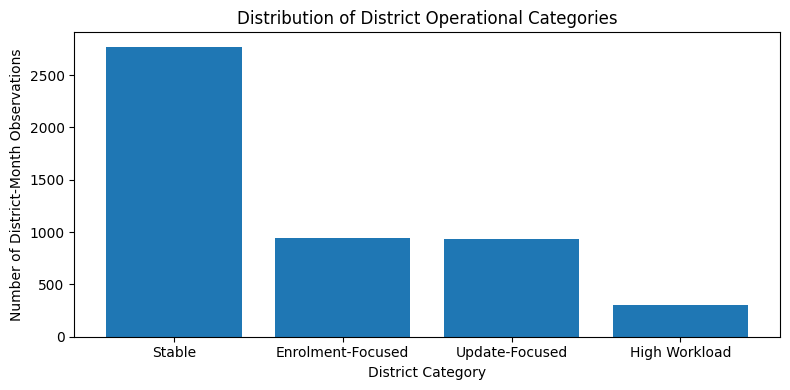

In [26]:
fig, ax = plt.subplots(figsize=(8,4))
ax.bar(category_counts['district_type'],category_counts['count'])
ax.set_xlabel('District Category')
ax.set_ylabel("Number of District-Month Observations")
ax.set_title("Distribution of District Operational Categories")

plt.tight_layout()
plt.show()

**Observation:** While the majority of districts operate under stable conditions, a non-trivial proportion experience either enrolment-focused or update-focused stress, and a smaller critical subset faces combined high enrolment pressure and high biometric update workload, indicating concentrated operational stress points.


In [27]:
analysis_df["district_type"].value_counts(normalize=True) * 100

district_type
Stable               55.934598
Enrolment-Focused    19.035123
Update-Focused       18.934195
High Workload         6.096084
Name: proportion, dtype: float64

“Only about ~6% of district-months fall into the Heavy Workload category.”

In [28]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
analysis_df.loc[:,['p_norm','b_norm']] = scaler.fit_transform(
    analysis_df[['pressure_score','biometric_total']]
)
analysis_df

,month,state,district,pressure_score,biometric_total,district_type,p_norm,b_norm
0,April,Assam,Baksa,0.022257,3072,Enrolment-Focused,0.708616,0.034499
1,April,Assam,Barpeta,0.088750,11969,Enrolment-Focused,0.759957,0.134446
2,April,Assam,Biswanath,0.067726,1786,Enrolment-Focused,0.743724,0.020052
3,April,Assam,Bongaigaon,0.030415,5647,Enrolment-Focused,0.714915,0.063426
4,April,Assam,Cachar,0.024674,12349,High Workload,0.710483,0.138715
...,...,...,...,...,...,...,...,...
4949,September,West Bengal,nadia,0.013969,1,Enrolment-Focused,0.702217,0.000000
4950,September,West bengal,hooghly,0.000000,4,Stable,0.691432,0.000034
4951,September,Westbengal,Hooghly,0.000000,5,Stable,0.691432,0.000045
4952,September,andhra pradesh,chittoor,0.000000,10,Stable,0.691432,0.000101


In [29]:
analysis_df.loc[:,'combined_stress'] = analysis_df['p_norm'] + analysis_df['b_norm']

C:\Users\palas\AppData\Local\Temp\ipykernel_18004\1661600572.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analysis_df.loc[:,'combined_stress'] = analysis_df['p_norm'] + analysis_df['b_norm']


In [30]:
top_heavy = (
    analysis_df[analysis_df['district_type']=='High Workload']
    .sort_values('combined_stress',ascending=False)
    .head(10)
)
top_heavy

,month,state,district,pressure_score,biometric_total,district_type,p_norm,b_norm,combined_stress
2526,November,Maharashtra,Nashik,0.017290,82610,High Workload,0.704782,0.928014,1.632796
2539,November,Maharashtra,Thane,0.022427,80050,High Workload,0.708748,0.899255,1.608003
1419,July,Maharashtra,Thane,0.016096,74661,High Workload,0.703860,0.838716,1.542576
1321,July,Gujarat,Ahmedabad,0.027703,65705,High Workload,0.712822,0.738106,1.450928
1855,May,Gujarat,Ahmedabad,0.021348,64796,High Workload,0.707915,0.727895,1.435810
54,April,Delhi,North West Delhi,0.015211,65071,High Workload,0.703176,0.730984,1.434160
1918,May,Maharashtra,Thane,0.045578,59673,High Workload,0.726623,0.670344,1.396967
150,April,Maharashtra,Thane,0.037197,52237,High Workload,0.720152,0.586809,1.306961
56,April,Delhi,South Delhi,0.017482,52703,High Workload,0.704930,0.592044,1.296974
2518,November,Maharashtra,Mumbai,0.032520,51310,High Workload,0.716541,0.576396,1.292936


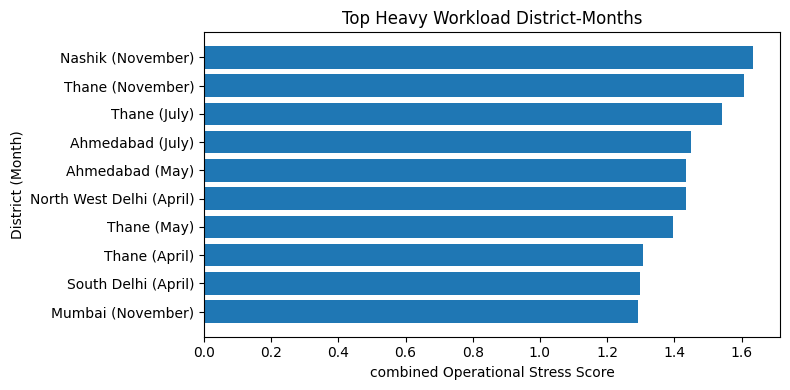

In [31]:
fig, ax = plt.subplots(figsize=(8,4))

ax.barh(
    top_heavy["district"] + " (" + top_heavy["month"] + ")",
    top_heavy['combined_stress']
)

ax.set_xlabel("combined Operational Stress Score")
ax.set_ylabel("District (Month)")
ax.set_title("Top Heavy Workload District-Months")

ax.invert_yaxis()
plt.tight_layout()
plt.show()


In [35]:
heavy_df = analysis_df[analysis_df["district_type"] == "High Workload"]

In [53]:
state_month_heavy = (
    heavy_df
    .groupby("state")
    .size()
    .reset_index(name="heavy_district_count")
    .sort_values('heavy_district_count',ascending=False)
)

In [54]:
state_month_heavy

,state,heavy_district_count
12,Maharashtra,64
18,Uttar Pradesh,37
5,Gujarat,30
0,Andhra Pradesh,28
11,Madhya Pradesh,26
20,West Bengal,17
14,Rajasthan,15
4,Delhi,15
2,Bihar,14
13,Punjab,14


In [55]:
top_state_month = (
    state_month_heavy
    .sort_values("heavy_district_count", ascending=False)
    .head(10)
)

top_state_month

,state,heavy_district_count
12,Maharashtra,64
18,Uttar Pradesh,37
5,Gujarat,30
0,Andhra Pradesh,28
11,Madhya Pradesh,26
20,West Bengal,17
14,Rajasthan,15
4,Delhi,15
2,Bihar,14
13,Punjab,14


### State-Months with Highest Concentration of Heavy Workload Districts

This chart shows state-month combinations where the number of districts facing combined operational stress is highest, indicating periods requiring elevated state-level support.


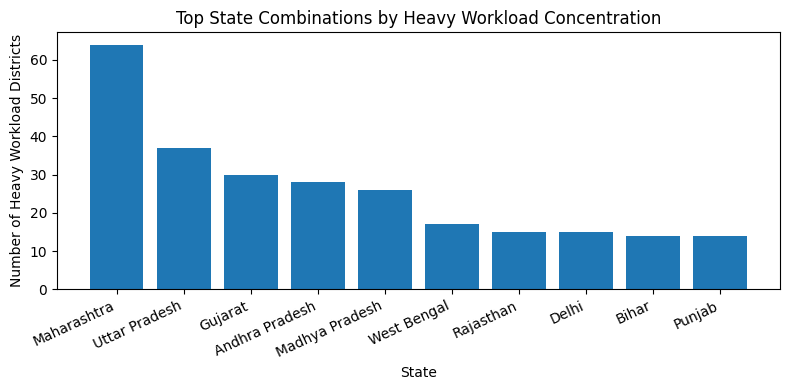

In [58]:
fig, ax = plt.subplots(figsize=(8,4))

labels = top_state_month["state"]

ax.bar(labels, top_state_month["heavy_district_count"])

ax.set_xlabel("State")
ax.set_ylabel("Number of Heavy Workload Districts")
ax.set_title("Top State Combinations by Heavy Workload Concentration")
plt.xticks(rotation=25, ha="right")
plt.tight_layout()
plt.show()